In [1]:
from active_model import MLP
import active_model
import generate_data
import numpy as np
import math
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [2]:
torch.manual_seed(0)


In [3]:
raw_data, options = generate_data.load_data()

dims of (x, y) are (11, 3)
there are 6 different conditions


In [4]:
hidden_dim = [32,32]
num_task = 6
spectral_norms = [False]*len(hidden_dim)
data_model = MLP(options["dim_x"], 6, hidden_dim, spectral_norms, num_task, True, False)

In [5]:
rng = np.arange(10,500,10)

## Best

### Training

In [6]:
shared_features = options["features"]
v = [1,0,0,0,0,0]

In [7]:
best_epoch_loss = []
best_predict_loss = []
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
for sample_size in rng:
  hidden_dim = [32,32]
  spectral_norms = [False]*len(hidden_dim)
  best_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
  optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=100, gamma=0.9) 
  train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = sample_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(best_model, train_dataset, 6, optimizer, i, False)
    scheduler.step()
  best_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(best_model.predict(test_dataset[0],test_dataset[1],k))
  best_predict_loss.append(predict_loss)


Text(0.5, 1.0, 'best sampling training loss')

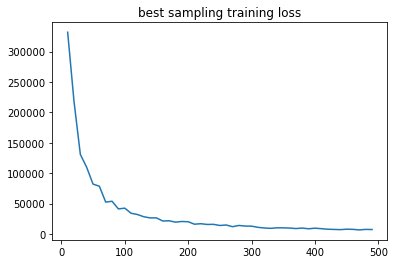

In [8]:
plt.plot(rng,best_epoch_loss)
plt.title("best sampling training loss")

### Predict on target

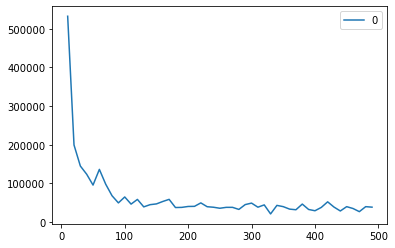

In [9]:
# target nn last layer loss
plt.plot(rng, np.array(best_predict_loss).T[0], label=0)
plt.legend()
plt.show()

## Uniform

In [10]:
num_task = 6
shared_features = options["features"]
v = np.array([1]*len(raw_data))
v = v / (len(raw_data))
sample_size = 500

In [11]:
uni_epoch_loss = []
uni_predict_loss = []
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
for sample_size in rng:  
  hidden_dim = [32,32]
  spectral_norms = [False]*len(hidden_dim)
  uni_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
  optimizer = optim.SGD(uni_model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
  train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = sample_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(uni_model, train_dataset, 6, optimizer, i, True)
    scheduler.step()
  uni_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(uni_model.predict(test_dataset[0],test_dataset[1],k))
  uni_predict_loss.append(predict_loss)
  

Train Epoch: 0 [total loss on source: 7023673.708333]
Train Epoch: 1 [total loss on source: 7023558.364583]
Train Epoch: 2 [total loss on source: 7023340.406250]
Train Epoch: 3 [total loss on source: 7023027.510417]
Train Epoch: 4 [total loss on source: 7022627.895833]
Train Epoch: 5 [total loss on source: 7022142.562500]
Train Epoch: 6 [total loss on source: 7021571.031250]
Train Epoch: 7 [total loss on source: 7020903.239583]
Train Epoch: 8 [total loss on source: 7020122.375000]
Train Epoch: 9 [total loss on source: 7019198.208333]
Train Epoch: 10 [total loss on source: 7018078.218750]
Train Epoch: 11 [total loss on source: 7016681.250000]
Train Epoch: 12 [total loss on source: 7014882.739583]
Train Epoch: 13 [total loss on source: 7012498.114583]
Train Epoch: 14 [total loss on source: 7009251.583333]
Train Epoch: 15 [total loss on source: 7004751.968750]
Train Epoch: 16 [total loss on source: 6998461.802083]
Train Epoch: 17 [total loss on source: 6989647.760417]
Train Epoch: 18 [tot

Text(0.5, 1.0, 'uniform sampling training loss')

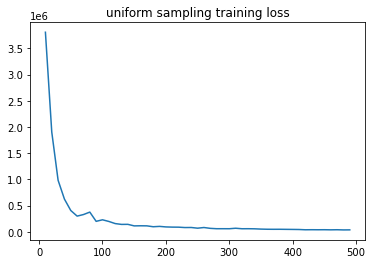

In [12]:
plt.plot(rng,uni_epoch_loss)
plt.title("uniform sampling training loss")

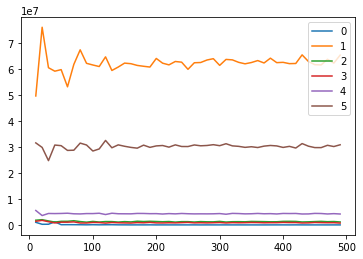

In [13]:
# last layer loss
for k in range(num_task):
    plt.plot(rng, np.array(uni_predict_loss).T[k], label=k)
plt.legend()
plt.show()

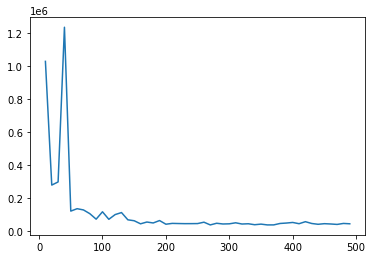

In [14]:
# target nn last layer
plt.plot(rng, np.array(uni_predict_loss).T[0], label=0)

## Compare

Text(0.5, 1.0, 'Compare Training Loss')

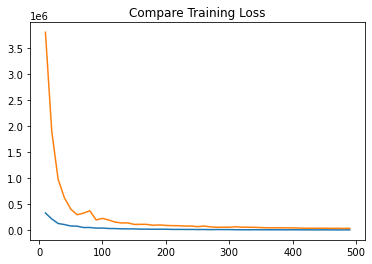

In [15]:
plt.plot(rng,best_epoch_loss, label="best training loss")
plt.plot(rng,uni_epoch_loss, label="uniform training loss")
plt.title("Compare Training Loss")

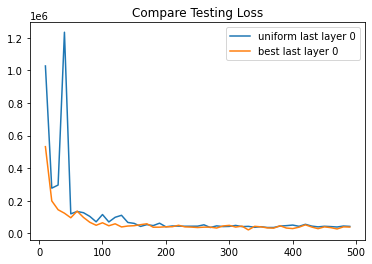

In [16]:
plt.plot(rng, np.array(uni_predict_loss).T[0], label="uniform last layer 0")
plt.plot(rng, np.array(best_predict_loss).T[0], label="best last layer 0")
plt.title("Compare Testing Loss")
plt.legend()
plt.show()